Using common risk factors to predict Heart Disease-the effect of age, serum cholesterol level, and resting blood pressure on disease diagnosis

Jacob Wang, Steven Suo, Jiamin Li, Athena Song

Introduction:

Heart disease(HD) can be described as any health condition that affects the heart, and it is often fatal if not treated at earlier stages. It can be diagnosed by many risk factors. Therefore, developing methods of the identification of HD based on the risk factors has become a top priority. This project is to develop a model based on the Cleveland dataset that could effectively identify HD based on three risk factors: age, serum cholesterol level, and resting blood pressure. This dataset includes both common risk factors and a number that represent disease status, with 0 being healthy and any other values being diseased.

Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
head(cleveland_data) 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
# cleaning, wrangling data
cleveland_data[ cleveland_data == "?" ] <- NA

cleveland_tidy <- cleveland_data |>
                    mutate(diag = ifelse(is.na(num), NA, (num > 0))) |>
                    mutate(sex = as.factor(sex), cp = as.factor(cp), 
                           fbs = as.factor(fbs), restecg = as.factor(restecg),
                           exang = as.factor(exang), thal = as.factor(thal),
                           ca = as.factor(ca), slope = as.factor(slope))

#splitting data into training sets 
cleveland_split <- initial_split(cleveland_tidy, prop = 3/4, strata = num)

cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
head(cleveland_train)
head(cleveland_test)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,FALSE


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,TRUE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1,TRUE
56,1,3,130,256,1,2,142,1,0.6,2,1.0,6.0,2,TRUE
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0,FALSE


In [4]:
cleveland_summary <- cleveland_train |>
                    group_by(diag) |>
                    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

diag,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,74,51.92683,126,564,244.2927,96,202,159.0163,123
TRUE,35,70,56.77670,131,407,253.3301,71,182,139.1262,103


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'chol'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trestbps'. You can override using the
`.groups` argument.
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


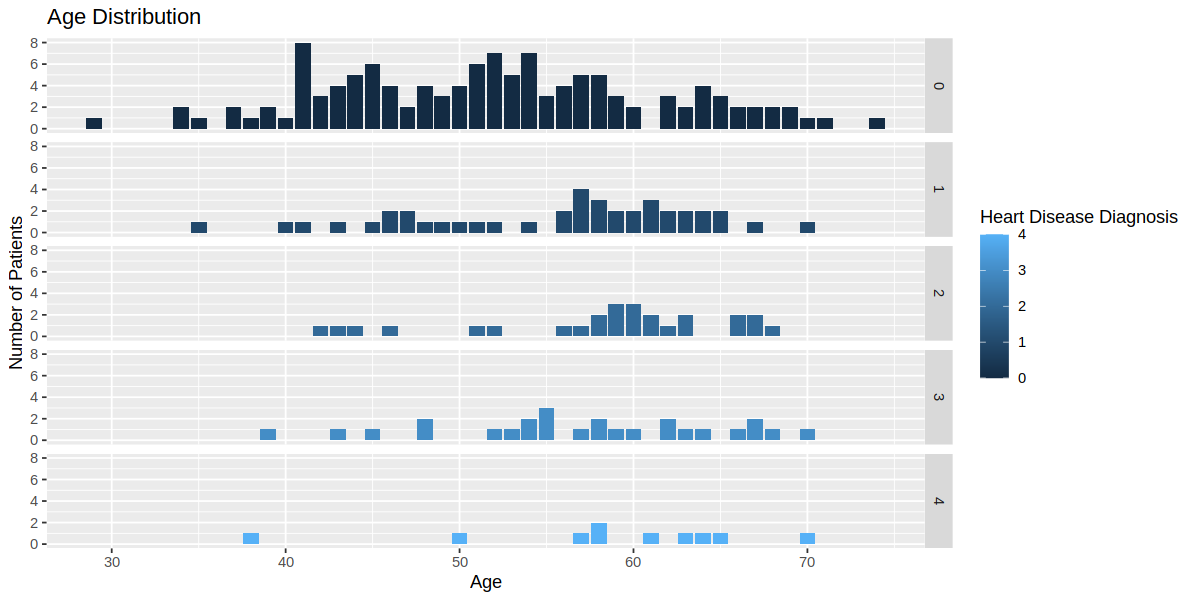

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


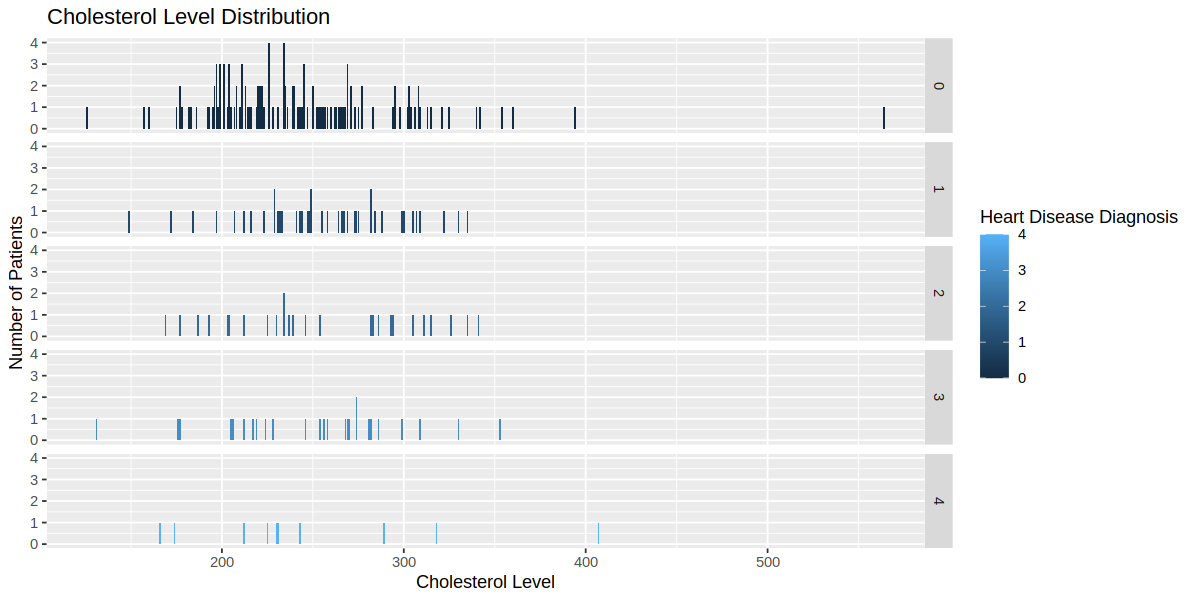

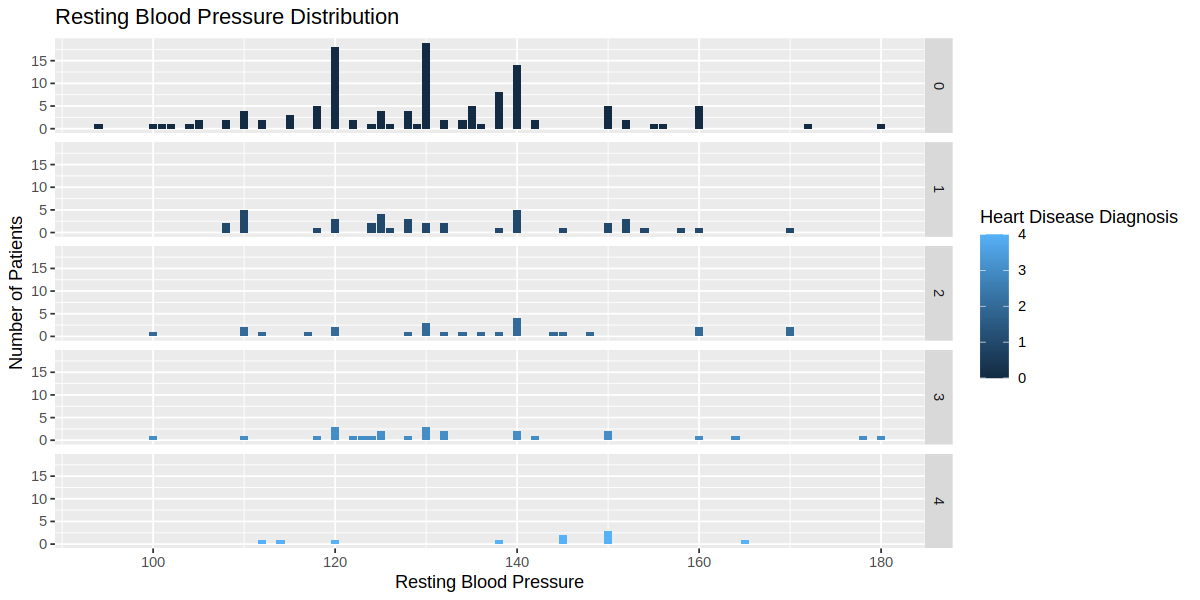

In [5]:
#get rid of the unknown data
tidier_data <- cleveland_train |> 
    filter(chol != "?" & trestbps != "?") |> 
    mutate(chol = as.numeric(chol) , trestbps = as.numeric(trestbps))

age_data <- tidier_data |>
    group_by(age, num) |>
    summarize(count = n()) |>
    ungroup()

chol_data <- tidier_data |>
    group_by(chol, num) |>
    summarize(count = n()) |>
    ungroup()

trestbps_data <- tidier_data |>
    group_by(trestbps, num) |>
    summarize(count = n()) |>
    ungroup()

options(repr.plot.width = 10, repr.plot.height = 5)

age_vs_count_plot <- age_data |>
    ggplot(aes(x = age, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Age", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Age Distribution")
age_vs_count_plot
# age_vs_count_plot

chol_vs_count_plot <- chol_data |>
    ggplot(aes(x = chol, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Cholesterol Level", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Cholesterol Level Distribution")
chol_vs_count_plot
# chol_vs_count_plot

trestbps_vs_count_plot <- trestbps_data |>
    ggplot(aes(x = trestbps, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Resting Blood Pressure", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Resting Blood Pressure Distribution")
trestbps_vs_count_plot


Method:

   We randomly chose variables based on some common sense, believing the selected variables are essential for diagnosing heart disease. The selected variables are "age," "cholesterol," and "resting blood pressure." After confirming the variables, we import the data from the web page into Jupyter, read it, and use classification 1/2 to classify the heart disease data set. 
   
   We used scatterplot (ggplot(point)) to visualize the results from analyzing the data set. The distribution of scattered dots in the image visualizes a sample of people diagnosed with heart disease so we can see what ranges of "age," "cholesterol," and "resting blood pressure" can be used to diagnose heart disease.



Discussion:

We expect to find if heart disease can be diagnosed with some common risk factors such as age, serum cholesterol level, and resting blood pressure. Upon completion of this project, we would be able to see the effect of each of the three factors on heart disease; specifically, we could potentially find answers to a variety of questions such as at what age people are more likely to get heart disease, what serum cholesterol level is considered abnormal and therefore can be an indicator of heart disease, or what the resting blood pressure of heart disease patients typically is like. However, it is possible for the three factors picked to be inadequate for identifying heart disease to begin with; in which case, we would have to explore if some other factors would have been better choices.

References:
Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
Finegold, J. A., Asaria, P., & Francis, D. P. (2013). Mortality from ischaemic heart disease by country, region, and age: statistics from World Health Organisation and United Nations. International journal of cardiology, 168(2), 934-945.https://doi.org/10.1016/j.ijcard.2012.10.046


